<a href="https://colab.research.google.com/github/NarciSource/Aivle--MiniProject-6-1/blob/main/4%EA%B8%B0_2.%20Aivle%20%EC%8A%A4%EC%BF%A8%20%EC%A7%80%EC%9B%90%20%EC%A7%88%EB%AC%B8%2C%20%EB%8B%B5%EB%B3%80%20%EC%B1%97%EB%B4%87%20%EB%A7%8C%EB%93%A4%EA%B8%B0_%EB%AA%A8%EB%8D%B8%EB%A7%81_aivler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 두가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 3단계 : 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇 2개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 설치

In [ ]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
!pip install gensim

ERROR: Operation cancelled by user


#### 2) 형태소 분석을 위한 라이브러리

In [ ]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
curl is already the newest version (7.81.0-1ubuntu1.14).
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done

In [ ]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
# !pip install mecab

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from keras import Input, Model
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

* 형태소 분석을 위한 함수를 제공합니다.

In [ ]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [ ]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions
* Google Colab 환경에서 진행을 권장합니다.
    * 구글 드라이브 바로 밑에 project 폴더를 만들고,
    * 데이터 파일을 복사해 넣습니다.

#### 1) Google Colab 환경 구축

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#ex : path = '/content/drive/MyDrive/project/'
path = '/content/drive/MyDrive/aivle/mp6/'

#### 2) 저장된 데이터 읽어오기
* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [ ]:
train = joblib.load(path+'train.pkl')
train.shape

(1155, 4)

In [ ]:
test = joblib.load(path+'test.pkl')
test.shape

(106, 4)

In [ ]:
clean_train_questions = joblib.load(path+'clean_train_questions.pkl')
clean_train_questions.shape

(1155,)

In [ ]:
clean_test_questions = joblib.load(path+'clean_test_questions.pkl')
clean_test_questions.shape

(106,)

## 2.챗봇1

* **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

In [ ]:
clean_train_questions = list(map(lambda s: s.split(), clean_train_questions))
clean_test_questions = list(map(lambda s: s.split(), clean_test_questions))


#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원),
    * window(컨텍스트 창의 크기),
    * max_vocab_size(고려할 최대 어휘 크기),
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

In [ ]:
vector_size=100

In [ ]:
from gensim.models import Word2Vec

# Word2Vec 모델 생성
wv_model = Word2Vec(
    sentences=clean_train_questions,
    vector_size=vector_size,
    window=10,
    min_count=5,
    workers=4,
    sg=-1
)

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [ ]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수 생성
def get_sent_embedding(model, embedding_size, tokenized_words):
    # 임베딩 벡터를 0으로 초기화
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    # 단어 개수 초기화
    n_words = 0
    # 모델 단어 집합 생성
    index2word_set = set(model.wv.key_to_index.keys())
    # 문장의 단어들을 하나씩 반복
    for word in tokenized_words:
        # 모델 단어 집합에 해당하는 단어일 경우에만
        if word in index2word_set:
            # 단어 개수 1 증가
            n_words += 1
            # 임베딩 벡터에 해당 단어의 벡터를 더함
            feature_vec = np.add(feature_vec, model.wv.get_vector(word))
    # 단어 개수가 0보다 큰 경우 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [ ]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [ ]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
train_data_vecs = get_dataset(clean_train_questions, wv_model, vector_size)
test_data_vecs = get_dataset(clean_test_questions, wv_model, vector_size)


* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다.
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [ ]:
# X와 y 데이터 분리
X = train_data_vecs
y = train['intent']

# Train-Test split
train_x, valid_x, train_y, valid_y = train_test_split(X, y, train_size=.8, stratify=y)

* 모델1

In [ ]:
# LightGBM 분류기 생성
model_lgbm = LGBMClassifier()
# 학습
model_lgbm.fit(train_x, train_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25483
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 100
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -5.219274
[LightGBM] [Info] Start training from score -5.036953
[LightGBM] [Info] Start training from score -5.036953
[LightGBM] [Info] Start training from score -5.036953
[LightGBM] [Info] Start training from score -5.036953
[LightGBM] [Info] Start training from score -2.858420
[LightGBM] [Info] Start training from score -4.882802
[LightGBM] [Info] Start training from score -5.036953
[LightGBM] [Info] Start training from score -4.882802
[LightGBM] [Info] Start training from score -5.036953
[LightGBM] [Info] Start training from score -3.938340
[LightGBM

LGBMClassifier()

In [ ]:
# 예측 및 검증
pred_y = model_lgbm.predict(valid_x)
print(classification_report(valid_y, pred_y))
print(accuracy_score(valid_y, pred_y))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       1.00      0.50      0.67         2
           8       0.15      0.38      0.22        13
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.33      1.00      0.50         1
          12       0.00      0.00      0.00         2
          13       0.50      0.25      0.33         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         2
          18       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* 모델2

In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
# 학습
model_rf.fit(train_x, train_y)

RandomForestClassifier()

In [ ]:
# 예측 및 검증
pred_y = model_rf.predict(valid_x)
print(classification_report(valid_y, pred_y))
print(accuracy_score(valid_y, pred_y))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       1.00      0.50      0.67         2
           8       0.13      0.23      0.17        13
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.50      1.00      0.67         1
          12       0.00      0.00      0.00         2
          13       0.33      0.25      0.29         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         2
          18       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* 모델 저장하기

In [ ]:
#학습된 LightGBM 모델 lgbm을 파일로 저장
joblib.dump(model_lgbm, path+"lgbm.pkl")

['/content/drive/MyDrive/aivle/mp6/lgbm.pkl']

### (3) 챗봇 구축

# 챗봇1
* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

In [ ]:
test_sample = test.sample(1)
q = test_sample['Q']
a = test_sample['intent']
q.values[0], a.values[0]

('면접 진행 시 고려되는 평가 요소는 무엇인가요?', 36)

In [ ]:
# 입력문장 벡터화
q_vector = get_dataset(q, wv_model, vector_size)

In [ ]:
# 분류 모델을 이용하여 intent 예측
intent = model_lgbm.predict(q_vector)
print(a.values[0] == intent[0])
print(train[train['intent']==intent[0]].sample()['A'].values[0], intent[0])

False
교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있으므로, 제공한 노트북을 사용해 주시기 바랍니다.

원활한 실습 환경을 위해 아래 명시된 사양 이상을 갖춘 노트북을 제공합니다. 
- CPU : I5 / RAM : 8GB / 여유저장공간 : 40GB 46


#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용.

In [ ]:
def get_answer1(question):
    q_vector = get_dataset([question], wv_model, vector_size)
    intent = model_lgbm.predict(q_vector)
    print(intent)

    return train[train['intent']==intent[0]].sample()['A']

In [ ]:
q = test.sample(1)['Q']
a = get_answer1(q)

print('Q:', q.values[0])
print('A:', a.values[0])

[8]
Q: 전공기초가 없는데 커리큘럼을 따라갈 수 있나요?
A: 기분전환을 해보세요.


In [ ]:
q = input().split()
a = get_answer1(q)

print('Q:', q)
print('A:', a.values[0])

교육지원금 줘요?
[8]
Q: ['교육지원금', '줘요?']
A: 많이 지쳤나봐요.


#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [ ]:
pred_y = model_lgbm.predict(test_data_vecs)
print(classification_report(test['intent'], pred_y))
print(accuracy_score(test['intent'], pred_y))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.20      0.50      0.29         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         2
           9       0.50      0.50      0.50         2
          10       1.00      0.50      0.67         2
          11       1.00      0.50      0.67         2
          12       1.00      0.50      0.67         2
          13       1.00      0.50      0.67         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         2
          18       0.33    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
            * Embedding + LSTM 모델
        * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [ ]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
tokenizer= Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    analyzer= Mecab.morphs,
)
# .fit_on_texts 이용하여 토크나이저 만들기
tokenizer.fit_on_texts(clean_train_questions)

In [ ]:
# 전체 토큰의 수 확인
len(tokenizer.word_index)

1178

In [ ]:
# 전체 토큰의 수가 vocab 사이즈가 됨
vocab_size = len(tokenizer.word_index)
# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행

#???
tokenizer.fit_on_texts(clean_train_questions)



# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
sequence_train = tokenizer.texts_to_sequences(clean_train_questions)
sequence_test = tokenizer.texts_to_sequences(clean_test_questions)

In [ ]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성
print(tokenizer.word_index)
# <PAD> 는 0으로 추가
pad = 0

{'?': 1, '나요': 2, '이': 3, '있': 4, '는': 5, '하': 6, '가': 7, '교육': 8, '지원': 9, '을': 10, '에': 11, '수': 12, '되': 13, '할': 14, '어': 15, '.': 16, '도': 17, '경우': 18, '한가요': 19, '은': 20, '가능': 21, '고': 22, '어떻게': 23, '를': 24, '면': 25, '으로': 26, ',': 27, '없': 28, '중': 29, '나': 30, '로': 31, '서류': 32, '궁금': 33, '합니다': 34, '한': 35, '해야': 36, '어떤': 37, '노트북': 38, '는데': 39, '에서': 40, '졸업': 41, '과': 42, '진행': 43, '인': 44, '싶': 45, '의': 46, '인가요': 47, '다': 48, '수강': 49, '해': 50, '과정': 51, '채용': 52, '시': 53, '안': 54, '만': 55, '받': 56, '먹': 57, '다른': 58, '연계': 59, '지': 60, '대면': 61, '게': 62, '좋': 63, '보': 64, '제출': 65, '지역': 66, '아': 67, '자': 68, '주': 69, '제공': 70, '공부': 71, '시간': 72, '것': 73, '들': 74, '증명서': 75, '기준': 76, '재': 77, '일': 78, '취업': 79, '합격': 80, '거': 81, '미취': 82, '업자': 83, '을까요': 84, '추가': 85, '뭔가요': 86, '했': 87, '테스트': 88, '수료': 89, '검사': 90, '와': 91, '뭐': 92, '참여': 93, '생': 94, '같': 95, '비대': 96, '장소': 97, '기간': 98, '실업': 99, '급여': 100, '야': 101, '너무': 102, '대학': 103, '아르바이트': 104, '프리랜

* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

count    1155.000000
mean        9.372294
std         5.024197
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        57.000000
dtype: float64


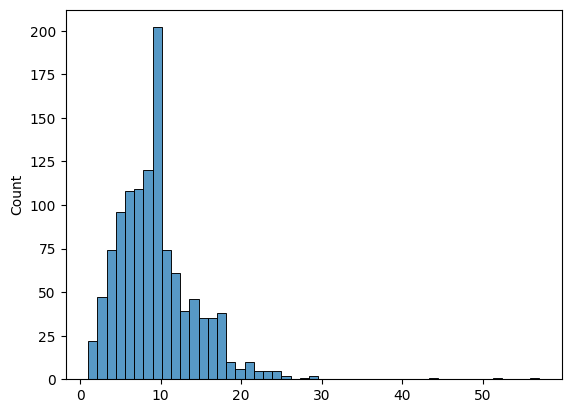

In [ ]:
# 문장별 토큰 수 카운트
token_count = list(map(len, sequence_train))
# 기초 통계량
print(pd.Series(token_count).describe())
# 분포 그래프
sns.histplot(token_count)
plt.show()

* 문장별 토큰이 가장 큰 것이 57개 입니다.

* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [ ]:
x_train_s = tf.keras.utils.pad_sequences(sequence_train,
                                         maxlen=vector_size,
                                         padding='post')
x_test_s = tf.keras.utils.pad_sequences(sequence_test,
                                        maxlen=vector_size,
                                        padding='post')
y_train_s = train['type']
y_test_s = test['type']

print(x_train_s.shape, y_train_s.shape, x_test_s.shape, y_test_s.shape)

(1155, 100) (1155,) (106, 100) (106,)


#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

In [ ]:
def rnn(x_train, y_train, x_test, y_test):

    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


    tf.keras.backend.clear_session()

    il = tf.keras.layers.Input(shape=x_train.shape[1:])


    hl = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=100)(il)

    hl = tf.keras.layers.LSTM(4, return_sequences=True)(hl)

    hl = tf.keras.layers.Flatten()(hl)

    hl = tf.keras.layers.Dense(64, activation='relu')(hl)
    hl = tf.keras.layers.Dense(16, activation='relu')(hl)
    ol = tf.keras.layers.Dense(y_train.shape[-1], activation='softmax')(hl)

    model_dl = tf.keras.Model(il, ol)
    model_dl.summary()

    model_dl.compile(loss=tf.keras.metrics.categorical_crossentropy,
          metrics=['accuracy'], optimizer='adam')

    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, restore_best_weights=True)

    history = model_dl.fit(x_train, y_train, epochs=1000, verbose=1,
                           batch_size = 32,
                           validation_split=0.2,
                           callbacks=[earlyStopping])

    sns.lineplot(history.history['accuracy'], label='train accuracy')
    sns.lineplot(history.history['val_accuracy'], label='val accuracy')
    plt.show()
    loss, acc = model_dl.evaluate(x_test, y_test)
    print("Accuracy: ", acc)
    return acc, model_dl

(1155, 100) (1155, 2) (106, 100) (106, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          117900    
                                                                 
 lstm (LSTM)                 (None, 100, 4)            1680      
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 64)                25664     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)   

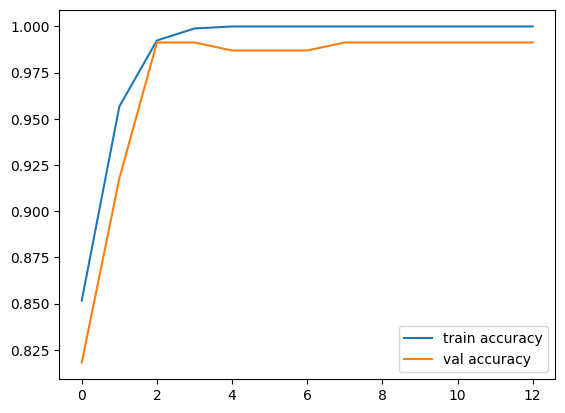

4/4 [==============================] - 0s 10ms/step - loss: 0.0391 - accuracy: 0.9717
Accuracy:  0.9716981053352356


0.9716981053352356

In [ ]:
acc, model_rnn = rnn(x_train_s, y_train_s, x_test_s, y_test_s)
acc

### (2) FastText 모델 : 사전학습된 Word2Vec 모델을 사용

-  FastText 모델 학습을 위한 입력 포맷 2차원 리스트 형태 입니다.
  ```
  [['나', '는', '학생', '이다'], ['오늘', '은', '날씨', '가', '좋다']]
  ```

- Word2Vec계열의 FastText를 학습하는 이유
  - n-gram이 추가된 fasttext 모델은 유사한 단어에 대한 임베딩을 word2vec보다 잘 해결할 수 있으며, 오탈자 등에 대한 임베딩 처리가 가능하다.
  - 예) 체크카드, 쳌카드는 word2vec에서는 전혀 다른 단어이지만 fasttext는 character n-gram으로 비교적 같은 단어로 처리할 수 있다.
- 참고: https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText


#### 1) 데이터 준비
* 시작데이터 : clean_train_questions, clean_test_questions

* FastText를 위한 입력 데이터 구조 만들기

#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

In [ ]:
vector_size = 100

In [ ]:
from gensim.models.fasttext import FastText
import gensim.models.word2vec

ft_model = FastText(clean_train_questions, vector_size=vector_size, window=5, min_count=5, workers=4, sg=1)

In [ ]:
# wv_model.wv.most_similar("마라탕")
# KeyError: "Key '마라탕' not present in vocabulary"

In [ ]:
ft_model.wv.most_similar("마라탕")

[('수', 0.0844462513923645),
 ('뻔', 0.08125340193510056),
 ('받', 0.07330978661775589),
 ('이', 0.0721646249294281),
 ('없', 0.07171546667814255),
 (',', 0.07142297923564911),
 ('야', 0.07113867253065109),
 ('할', 0.07098875939846039),
 ('있', 0.07078245282173157),
 ('지원', 0.07049672305583954)]

#### 3) train에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [ ]:
embeddings = [get_sent_embedding(ft_model, vector_size, q) for q in train['Q']]
embeddings = np.array(embeddings)

### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [ ]:
test_sample = test.sample(1)
q = test_sample['Q']
a = test_sample['intent']
q.values[0], a.values[0]

('공황장애 있어', 9)

* 예측을 위한 입력 형태로 변환

In [ ]:
x = get_sent_embedding(ft_model, vector_size, q)
x = np.array([x])
x.shape

(1, 100)

* 예측하기

In [ ]:
np.argmax(model_rnn.predict(x))

1/1 [==============================] - 1s 533ms/step


0

* 질문에 대한 벡터 만들기
    * FestText 모델로 부터 벡터 만들기

* train의 질문 벡터들과 유사도 계산
    * FastText 로 만들 벡터들과 유사도 계산

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(x, embeddings)
cs

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
idx = cs.argmax()
train.iloc[idx]['Q'], train.iloc[idx]['intent']

('떨어뜨려서 핸드폰 액정 나갔어', 1)

#### 2) 함수로 생성하기

In [ ]:
def get_answer2(question):
    x = get_sent_embedding(ft_model, vector_size, question)
    x = np.array([x])

    #type_pred = np.argmax(model_rnn.predict(x))

    idx = cosine_similarity(x, embeddings).argmax()
    intent_pred = train.iloc[idx]['intent']

    print(train[train['intent']==intent_pred].sample()['A'])
    return intent_pred

In [ ]:
get_answer2("다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요")

1/1 [==============================] - 0s 28ms/step
779    KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
Name: A, dtype: object


53

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [ ]:
pred = test['Q'].apply(get_answer2)

1/1 [==============================] - 0s 33ms/step
6    AS센터에 맡겨보세요.
Name: A, dtype: object
1/1 [==============================] - 0s 36ms/step
11    AS센터에 맡겨보세요.
Name: A, dtype: object
1/1 [==============================] - 0s 41ms/step
26    가장 중요한 목표네요.
Name: A, dtype: object
1/1 [==============================] - 0s 64ms/step
21    가장 중요한 목표네요.
Name: A, dtype: object
1/1 [==============================] - 0s 38ms/step
294    많이 만나보세요.
Name: A, dtype: object
1/1 [==============================] - 0s 54ms/step
129    힘들겠네요.
Name: A, dtype: object
1/1 [==============================] - 0s 41ms/step
78    같이 가자고 말해보세요
Name: A, dtype: object
1/1 [==============================] - 0s 39ms/step
124    기분전환을 해보세요.
Name: A, dtype: object
1/1 [==============================] - 0s 45ms/step
245    KT 에이블스쿨은 별도의 면접 과정이 없습니다
Name: A, dtype: object
1/1 [==============================] - 0s 40ms/step
758    숙소 및 기숙사에 대한 지원은 제공하지 않습니다.
Name: A, dtype: object
1/1 [==============================] -

In [ ]:
accuracy_score(test['intent'], pred)

0.5377358490566038

# 새 섹션

## 5.질문에 대한 답변 비교해보기

* **세부요구사항**
    * 세가지 챗봇을 생성해 보았습니다.
    * 질문을 입력하여 답변을 비교해 봅시다. 어떤 챗봇이 좀 더 정확한 답변을 하나요?


In [ ]:
q = input()

print("Chatbot-1")
print('A:', get_answer1(q.split()).values[0])
print('\n')
print("Chatbot-2")
print("A:", get_answer2(q))

점심 뭐 먹을까
Chatbot-1
[11]
A: 냉장고 파먹기 해보세요.


Chatbot-2
1/1 [==============================] - 0s 26ms/step
202    냉장고 파먹기 해보세요.
Name: A, dtype: object
A: 11
